In [234]:
# Import libaries
import re
import importlib


In [235]:
# Libary to import self-made libaries
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway\Libaries')

In [362]:
# Importing self-made libaries
import standards as s
import Monte_Carlo as MC
import life_cycle_assessment as lc
import LCA_plots as lp

# Reload to reset the state of the self-made libaries
# https://dev.to/fronkan/importlib-reload-for-resting-modules-between-tests-neh
importlib.reload(s)
importlib.reload(MC)
importlib.reload(lc)
importlib.reload(lp)

<module 'LCA_plots' from 'C:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\Libaries\\LCA_plots.py'>

In [273]:
# Specifying if it is CONSQ (consequential) or APOS
db_type = 'CONSQ'

# Specifying the LCIA method
lcia_method = 'recipe'


In [238]:

# Path to where the code is stored
path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

file_identifier = 'Ananas'
res_folder_identifier = ' Ofir'

# Specifying the file name and sheet name
file_name = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}.xlsx'
sheet_name = f'{file_identifier}'

# Creating the saving directory for the results
save_dir = s.results_folder(path, 'Results', res_folder_identifier)

# Let the use decide the project and database
database_project, database_name = lc.select_project_and_database()

# Creating the flow legend
flow_legend = ['H2R',
               'H2S',
               'ASC',
               'ASW',
               'H4R',
               'H4S',
               'ALC',
               'ALW'
               ]



Folder name Results created
The chosen project is SU_vs_MU and the chosen database is sterilization


In [274]:
flows = lc.get_database_type_flows(database_project, database_name, db_type)

flows

['H200 REC - CONSQ',
 'H200 SU - CONSQ',
 'H400 REC- CONSQ',
 'H400 SU - CONSQ',
 'alubox large + washer - CONSQ',
 'alubox large + wipe - CONSQ',
 'alubox small + washer - CONSQ',
 'alubox small + wipe - CONSQ']

In [194]:
# flows = lc.get_user_specific_flows(database_project, database_name)
# flows

choose 'y' if you want to calculate for this flow, and 'n' if not


['H200 REC - APOS',
 'H200 SU - APOS',
 'H400 REC - APOS',
 'H400 SU - APOS',
 'alubox large + washer - APOS',
 'alubox large + wipe - APOS',
 'alubox small + washer - APOS',
 'alubox small + wipe - APOS']

In [275]:
initialization = [database_project, database_name, flows, lcia_method, db_type]
file_name_unique = f'{path}\Results\{file_identifier} - {db_type}_{lcia_method}_unq.xlsx'

In [276]:
df, plot_x_axis_all, impact_categories = lc.quick_LCIA(initialization, file_name_unique, sheet_name)

Recipe is selected
Initialization is completed
No new entries found


In [277]:
# df, impact_category, plot_x_axis_all, func_unit = lc.calculate_lcia(calculate=False, initialization=initialization, file_name=file_name, sheet_name=sheet_name)
# df

In [278]:
redo = False
df = lc.recalculate_lcia(redo, df, initialization, file_name, sheet_name)


In [279]:
rearrange = True
df_rearranged = lc.rearrange_dataframe_index(rearrange, df)

In [280]:
if 'recipe' in lcia_method:
    df_res, df_endpoint = lc.recipe_dataframe_split(df_rearranged)
    plot_x_axis_end = plot_x_axis_all[-3:]
    ic_mid = plot_x_axis_all[:-3] 
    plot_x_axis = []
    for ic in ic_mid:
        # print(ic)
        string = re.findall(r'\((.*?)\)', ic)
        plot_x_axis.append(string[0])

else:
    df_res = df_rearranged
    plot_x_axis = plot_x_axis_all


In [281]:
# if calculate_cont == True:
#     sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
#     FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, f'df_idx_ofir_{db_type}', lcia_method, db_type)
#     flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)
#     fu_sub_updated = lc.process_update(FU, functional_unit_sub)
    
#     df_cont = lc.LCIA_contribution(impact_category[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)
#     lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impact_category)
#     df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])


In [295]:
df_tot, df_scaled = lc.dataframe_element_scaling(df_res)
df_col = [df_res.columns[1]]
df_GWP = df_res[df_col]

unique_elements = lc.unique_elements_list(database_name)
colors = s.plot_colors(unique_elements,'turbo')


inputs = [flow_legend, colors, save_dir, db_type, database_name]

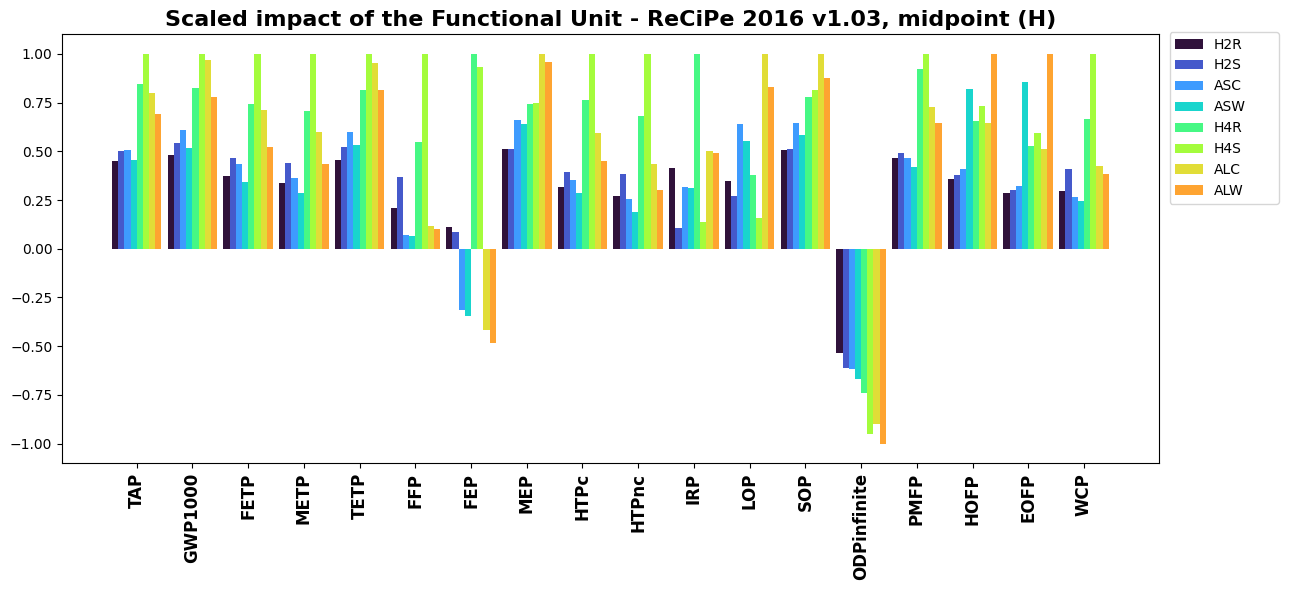

In [296]:
leg_pos_mid = .605

lp.scaled_FU_plot(df_scaled, plot_x_axis, inputs, impact_categories, leg_pos_mid)

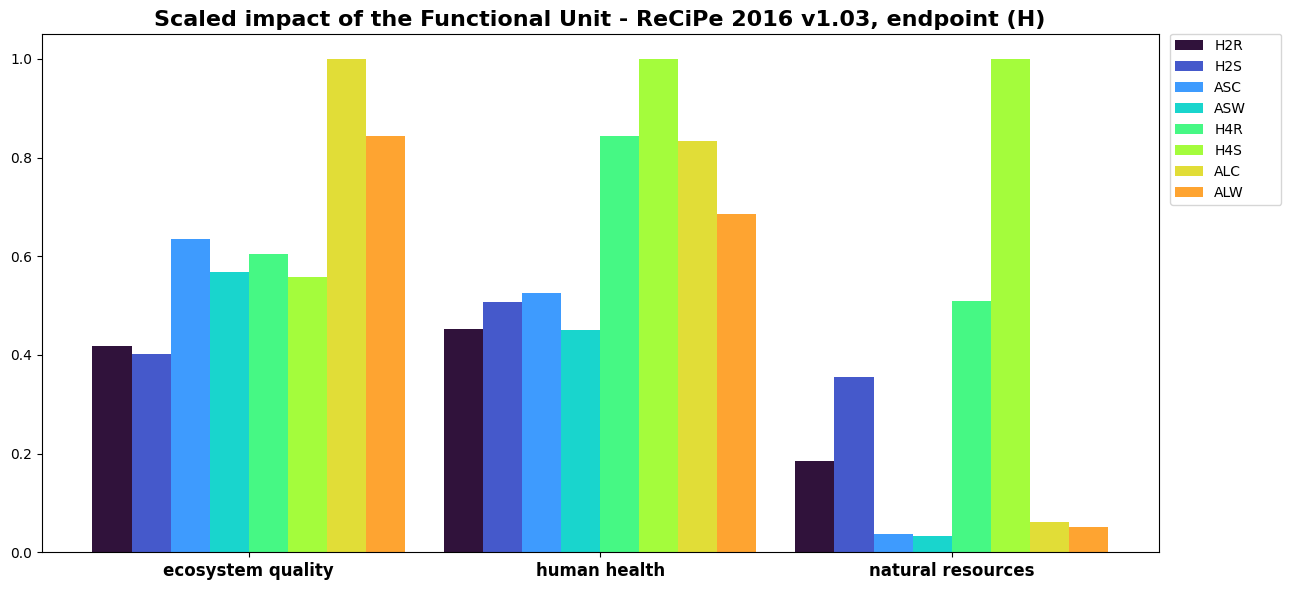

In [297]:
leg_pos_end = 0.67
if 'recipe' in lcia_method.lower():
    df_tot_e, df_scaled_e = lc.dataframe_element_scaling(df_endpoint)
    lp.scaled_FU_plot(df_scaled_e, plot_x_axis_end, inputs, impact_categories[-3:], leg_pos_end)


In [298]:
if 'recipe' not in lcia_method:
    directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
    lp.single_score_plot(directory, df_tot, colors, flow_legend, save_dir, db_type)

Total for H200 REC - CONSQ = 0.41243069356891193 kg CO2e
Total for H200 SU - CONSQ = 0.4650188852167797 kg CO2e
Total for alubox small + washer - CONSQ = 0.5242194239459472 kg CO2e
Total for alubox small + wipe - CONSQ = 0.44283590672714424 kg CO2e
Total for H400 REC- CONSQ = 0.7099790231998484 kg CO2e
Total for H400 SU - CONSQ = 0.860323116545504 kg CO2e
Total for alubox large + washer - CONSQ = 0.8313473795273185 kg CO2e
Total for alubox large + wipe - CONSQ = 0.6685803450897122 kg CO2e


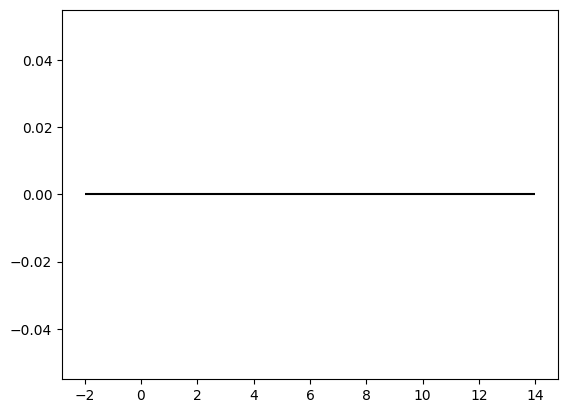

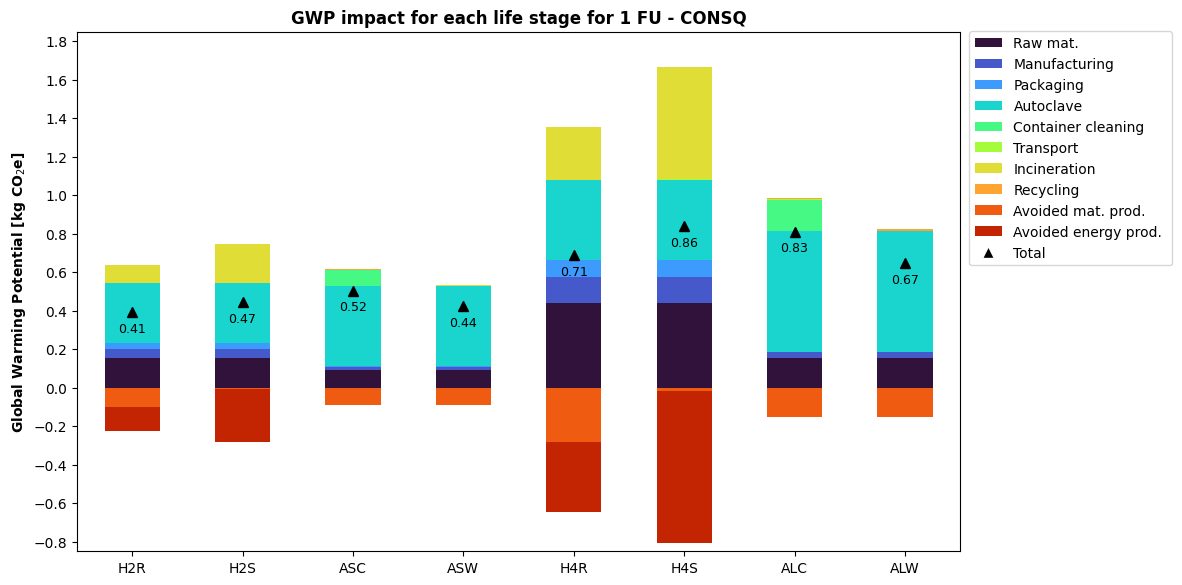

In [363]:

y_min = -.8
y_max = 1.8
step = 0.2
leg_pos = 0.55
y_axis_values = [y_min, y_max, step, leg_pos]
df_stacked = lp.gwp_scenario_plot(df_GWP, inputs, y_axis_values)


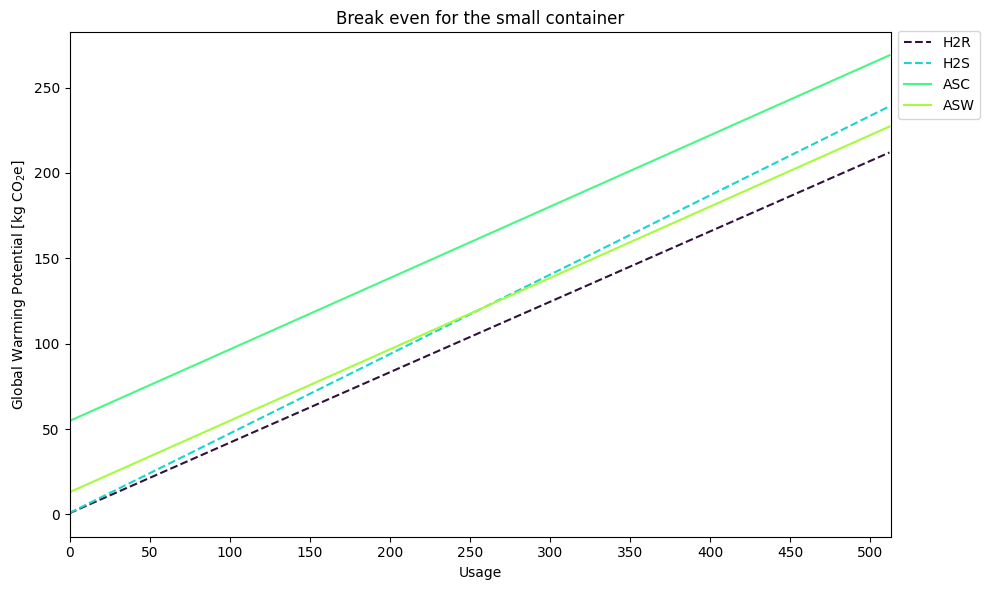

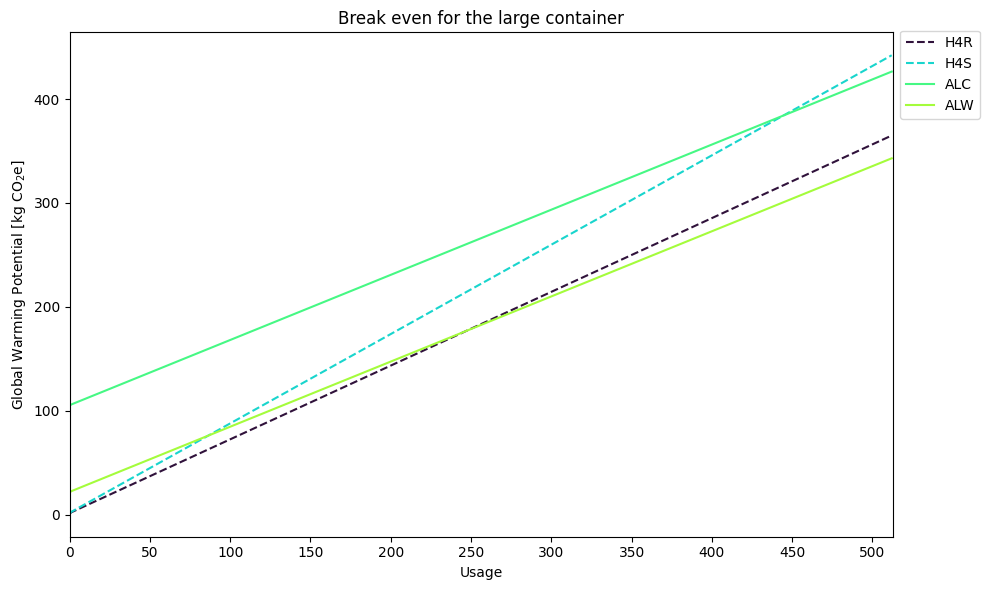

In [300]:
amount_of_uses = 513
lp.break_even_graph(df_stacked, inputs, amount_of_uses)